<a href="https://colab.research.google.com/github/rakesh-sengupta/vwm-change-detect/blob/main/Python_Error_Rate_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing set size: 2
Processing set size: 3
Processing set size: 4
Processing set size: 5
Processing set size: 6
Processing set size: 7
Processing set size: 8


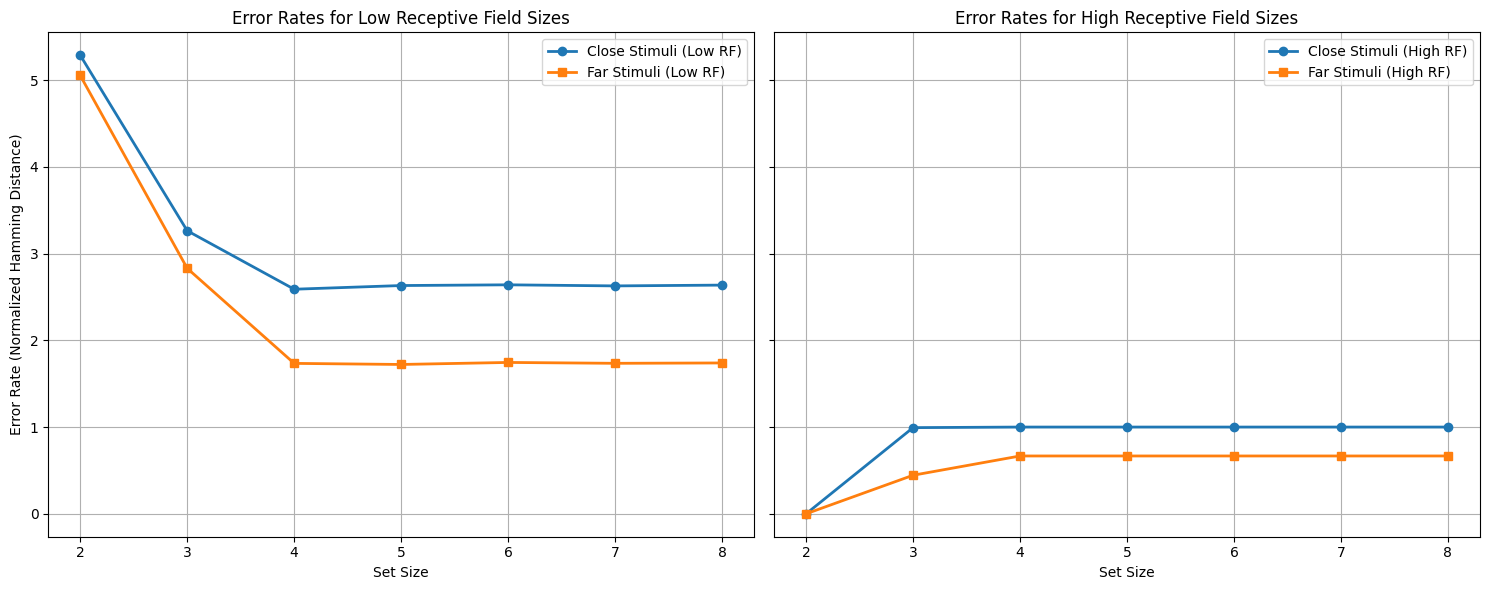

In [3]:
# Copyright (C) 2024 Rakesh Sengupta (Original Octave Code)
# Python version
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

import numpy as np
import matplotlib.pyplot as plt
import math

# Helper function to convert 1-based linear Octave index to 1-based (row, col)
# In Octave, indices are typically column-major.
# sub2ind(siz, row, col) -> (col-1)*siz(1) + row
# ind2sub(siz, ind) -> [row = rem(ind-1,siz(1))+1, col = floor((ind-1)/siz(1))+1]
def ind2sub_1based(linear_idx_1based, grid_dim_rows):
    """Converts a 1-based linear index to 1-based (row, col) subscripts for a grid,
    assuming column-major order like Octave/MATLAB."""
    if not (1 <= linear_idx_1based <= grid_dim_rows * grid_dim_rows): # Assuming square grid
        raise ValueError("Linear index is out of bounds.")
    col_1based = (linear_idx_1based - 1) // grid_dim_rows + 1
    row_1based = (linear_idx_1based - 1) % grid_dim_rows + 1
    return row_1based, col_1based

def sub2ind_1based(row_1based, col_1based, grid_dim_rows):
    """Converts 1-based (row, col) subscripts to a 1-based linear index,
    assuming column-major order."""
    if not (1 <= row_1based <= grid_dim_rows and 1 <= col_1based <= grid_dim_rows): # Assuming square grid
         raise ValueError("Subscripts are out of bounds.")
    return (col_1based - 1) * grid_dim_rows + row_1based

def generate_close_inputs(num_inputs, N):
    """
    Generate close input nodes radially around the center (3x3 central region).
    Python version using 0-based indexing for the output array I.
    """
    I = np.zeros(N)
    grid_dim = int(math.sqrt(N)) # Size of the grid (e.g., 8 for N=64)

    if grid_dim * grid_dim != N:
        raise ValueError("N must be a perfect square for grid operations.")

    # Center node in 1-based indexing (Octave: sub2ind([8, 8], 4, 4))
    # For an 8x8 grid, this is row 4, col 4.
    # Using a fixed center for an 8x8 grid as in the Octave example.
    # If grid_dim can change, this part might need to be more dynamic.
    if grid_dim == 8:
        center_r_1based, center_c_1based = 4, 4
    else:
        # Generic center (can be adjusted if non-8x8 grids are expected)
        center_r_1based = grid_dim // 2 + 1
        center_c_1based = grid_dim // 2 + 1

    center_node_1based = sub2ind_1based(center_r_1based, center_c_1based, grid_dim)

    # Define close region using 1-based linear indices relative to center_node_1based
    # These offsets correspond to one step in primary directions in a column-major grid
    # node_up    = center_node_1based - 1 (if center_node_1based > 1 and (center_node_1based-1-1)//grid_dim == (center_node_1based-1)//grid_dim )
    # node_down  = center_node_1based + 1 (if center_node_1based < N and ... )
    # node_left  = center_node_1based - grid_dim
    # node_right = center_node_1based + grid_dim

    potential_close_nodes_1based = []
    # Up (decrease row index)
    if center_r_1based > 1:
        potential_close_nodes_1based.append(sub2ind_1based(center_r_1based - 1, center_c_1based, grid_dim))
    # Down (increase row index)
    if center_r_1based < grid_dim:
         potential_close_nodes_1based.append(sub2ind_1based(center_r_1based + 1, center_c_1based, grid_dim))
    # Left (decrease col index)
    if center_c_1based > 1:
        potential_close_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based - 1, grid_dim))
    # Right (increase col index)
    if center_c_1based < grid_dim:
        potential_close_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based + 1, grid_dim))

    # Convert to 0-based indices for Python
    close_region_0based = [idx - 1 for idx in potential_close_nodes_1based]

    # Ensure unique selection and handle cases where num_inputs > available nodes
    num_to_select = min(num_inputs, len(close_region_0based))
    if num_to_select > 0 and len(close_region_0based) > 0 :
        selected_nodes_0based = np.random.choice(close_region_0based, size=num_to_select, replace=False)
        for node_idx in selected_nodes_0based:
            I[node_idx] = 1  # Set input to the selected nodes
    return I

def generate_far_inputs(num_inputs, N):
    """
    Generate far input nodes radially 3 units away from the center.
    Python version using 0-based indexing for the output array I.
    """
    I = np.zeros(N)
    grid_dim = int(math.sqrt(N))

    if grid_dim * grid_dim != N:
        raise ValueError("N must be a perfect square for grid operations.")

    if grid_dim == 8:
        center_r_1based, center_c_1based = 4, 4
    else:
        center_r_1based = grid_dim // 2 + 1
        center_c_1based = grid_dim // 2 + 1

    potential_far_nodes_1based = []
    distance = 3
    # Up by distance
    if center_r_1based - distance >= 1:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based - distance, center_c_1based, grid_dim))
    # Down by distance
    if center_r_1based + distance <= grid_dim:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based + distance, center_c_1based, grid_dim))
    # Left by distance
    if center_c_1based - distance >= 1:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based - distance, grid_dim))
    # Right by distance
    if center_c_1based + distance <= grid_dim:
        potential_far_nodes_1based.append(sub2ind_1based(center_r_1based, center_c_1based + distance, grid_dim))

    far_region_0based = [idx - 1 for idx in potential_far_nodes_1based]

    num_to_select = min(num_inputs, len(far_region_0based))
    if num_to_select > 0 and len(far_region_0based) > 0:
        selected_nodes_0based = np.random.choice(far_region_0based, size=num_to_select, replace=False)
        for node_idx in selected_nodes_0based:
            I[node_idx] = 1
    return I


def activation_function(x):
    """Activation function."""
    # Element-wise max(0, x / (1 + x))
    return np.maximum(0, x / (1 + x + 1e-9)) # Added epsilon to avoid division by zero if x = -1

def compute_distance_dependent_beta(N, beta_0, receptive_field_size):
    """Compute distance-dependent beta matrix."""
    beta_matrix = np.zeros((N, N))
    grid_dim = int(math.sqrt(N))

    if grid_dim * grid_dim != N:
        raise ValueError("N must be a perfect square for grid operations.")

    coords_1based = [ind2sub_1based(i + 1, grid_dim) for i in range(N)] # Get (r,c) for all nodes (1-based)

    for i in range(N):
        for j in range(N):
            if i == j:
                beta_matrix[i, j] = 0  # No self-inhibition
            else:
                r_i, c_i = coords_1based[i]
                r_j, c_j = coords_1based[j]

                # Euclidean distance
                delta_r = math.sqrt((r_i - r_j)**2 + (c_i - c_j)**2)

                # Distance-dependent inhibition
                beta_matrix[i, j] = beta_0 * math.exp(-delta_r**2 / (2 * receptive_field_size**2 + 1e-9)) # Epsilon for stability
    return beta_matrix

def simulate_network_and_compute_hamming(I_input, receptive_field_size, alpha, beta_0, dt, T_input, timesteps, noise_std):
    """Simulate the network and compute Hamming distance."""
    N = len(I_input)
    x = np.zeros(N)  # Initial state of nodes (1D array)
    # x_history = np.zeros((N, timesteps)) # To store the dynamics (not strictly needed for final Hamming distance)

    beta_matrix = compute_distance_dependent_beta(N, beta_0, receptive_field_size)

    # Simulate the dynamics
    for t_idx in range(int(timesteps)):
        noise = noise_std * np.random.randn(N)  # Gaussian noise (1D array)
        F_x = activation_function(x)  # Activation function for current state (1D array)

        # Apply transient input only for time <= T_input
        # (t_idx + 1) * dt is the time at the end of the current timestep
        if (t_idx + 1) * dt <= T_input:
            current_input = I_input
        else:
            current_input = np.zeros(N)

        # Update the state for each node (all are 1D arrays of size N)
        # beta_matrix @ F_x is matrix-vector product
        dx = -x + alpha * F_x - (beta_matrix @ F_x) + current_input + noise
        x = x + dx * dt  # Euler integration

        # x_history[:, t_idx] = x # Store state if needed for other analyses

    # Calculate Hamming distance between input and final output
    final_output = (x > 0.5).astype(int)  # Binarize output

    sum_I = np.sum(I_input)
    if sum_I == 0: # Avoid division by zero if no inputs were active (should not happen with set_sizes >=2)
        if np.sum(final_output) == 0: # No active inputs, no active outputs
            hamming_distance = 0.0
        else: # No active inputs, but some active outputs (all errors)
            hamming_distance = 1.0 # Or could be np.sum(final_output != I_input) / N if that's preferred
    else:
        # This is the Hamming distance normalized by the number of active inputs, as in original.
        hamming_distance = np.sum(final_output != I_input) / sum_I

    return hamming_distance

def average_hamming_distance(I_input_func, num_inputs_for_I, N_nodes, receptive_field_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations):
    """Calculate average Hamming distance over multiple simulations."""
    total_hamming_distance = 0
    for _ in range(num_simulations):
        # Generate new inputs for each simulation run
        I_current = I_input_func(num_inputs_for_I, N_nodes)
        if np.sum(I_current) == 0 and num_inputs_for_I > 0 : # Ensure inputs are generated if expected
             # This might happen if num_inputs > available locations for close/far stimuli
             # In this case, skip simulation or handle as error, here we'll get 0 hamming distance.
             # Or, one could argue the error is maximal if inputs were expected but not generated.
             # For simplicity, if I_current is all zeros, hamming_distance will likely be 0 or near 0.
             # The original code might implicitly handle this if randsample returns empty.
             pass # Let simulate_network_and_compute_hamming handle it.

        total_hamming_distance += simulate_network_and_compute_hamming(
            I_current, receptive_field_size, alpha, beta_0, dt, T_input, timesteps, noise_std
        )
    return total_hamming_distance / num_simulations


def error_rate_analysis_py():
    """Main error rate analysis function."""
    # Parameters
    N = 64  # Number of nodes (8x8 grid)
    # grid_size = int(math.sqrt(N)) # Size of the grid (derived where needed)
    dt = 0.01  # Time step
    T_total = 10  # Total simulation time
    T_input = 1  # Duration of input (transient)
    timesteps = T_total / dt  # Number of timesteps
    noise_std = 0.03  # Noise standard deviation
    alpha = 2.0  # Fixed value for alpha
    beta_0 = 0.3  # Standard value for beta
    num_simulations = 100  # Number of simulations for averaging (Original was 100, reduce for quick testing if needed)

    # Receptive field sizes
    low_receptive_field_sizes = [0.5, 1.0, 2.0]
    high_receptive_field_sizes = [4.0, 8.0, 16.0]

    # Set sizes to evaluate
    set_sizes = np.arange(2, 8 + 1)  # Number of inputs vary between 2-8

    error_rates_close_low = np.zeros(len(set_sizes))
    error_rates_far_low = np.zeros(len(set_sizes))
    error_rates_close_high = np.zeros(len(set_sizes))
    error_rates_far_high = np.zeros(len(set_sizes))

    # Loop through set sizes
    for i, num_inputs in enumerate(set_sizes):
        print(f"Processing set size: {num_inputs}") # Progress indicator

        # --- Low Receptive Field Sizes ---
        # Close stimuli
        errors_temp_close_low = [
            average_hamming_distance(generate_close_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in low_receptive_field_sizes
        ]
        error_rates_close_low[i] = np.mean(errors_temp_close_low)

        # Far stimuli
        errors_temp_far_low = [
            average_hamming_distance(generate_far_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in low_receptive_field_sizes
        ]
        error_rates_far_low[i] = np.mean(errors_temp_far_low)

        # --- High Receptive Field Sizes ---
        # Close stimuli
        errors_temp_close_high = [
            average_hamming_distance(generate_close_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in high_receptive_field_sizes
        ]
        error_rates_close_high[i] = np.mean(errors_temp_close_high)

        # Far stimuli
        errors_temp_far_high = [
            average_hamming_distance(generate_far_inputs, num_inputs, N, rf_size, alpha, beta_0, dt, T_input, timesteps, noise_std, num_simulations)
            for rf_size in high_receptive_field_sizes
        ]
        error_rates_far_high[i] = np.mean(errors_temp_far_high)

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Plot for low receptive field sizes
    axs[0].plot(set_sizes, error_rates_close_low, '-o', label='Close Stimuli (Low RF)', linewidth=2)
    axs[0].plot(set_sizes, error_rates_far_low, '-s', label='Far Stimuli (Low RF)', linewidth=2)
    axs[0].set_xlabel('Set Size')
    axs[0].set_ylabel('Error Rate (Normalized Hamming Distance)')
    axs[0].set_title('Error Rates for Low Receptive Field Sizes')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for high receptive field sizes
    axs[1].plot(set_sizes, error_rates_close_high, '-o', label='Close Stimuli (High RF)', linewidth=2)
    axs[1].plot(set_sizes, error_rates_far_high, '-s', label='Far Stimuli (High RF)', linewidth=2)
    axs[1].set_xlabel('Set Size')
    # axs[1].set_ylabel('Error Rate (Hamming Distance)') # Shared Y-axis
    axs[1].set_title('Error Rates for High Receptive Field Sizes')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set a seed for reproducibility if desired
    # np.random.seed(42)
    error_rate_analysis_py()

In [4]:
import numpy as np

def activation_function(x):
    """
    Sigmoid activation function.
    F(x) = 1 / (1 + exp(-x))
    """
    return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500))) # Clip to avoid overflow with exp

def get_grid_info(N_sqrt):
    """
    Computes node positions and Euclidean distances for a 2D square grid.

    Args:
        N_sqrt (int): The square root of the total number of nodes (e.g., 8 for an 8x8 grid).

    Returns:
        tuple: (node_positions, distances)
            - node_positions (np.array): Nx2 array where N is N_sqrt*N_sqrt. Each row is [row_coord, col_coord].
            - distances (np.array): NxN matrix of Euclidean distances between nodes.
    """
    N = N_sqrt * N_sqrt
    node_positions = np.zeros((N, 2))
    for i in range(N):
        node_positions[i, 0] = i // N_sqrt  # row index
        node_positions[i, 1] = i % N_sqrt   # column index

    distances = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            distances[i,j] = np.linalg.norm(node_positions[i] - node_positions[j])
    return node_positions, distances

def compute_beta_matrix(N, distances, beta_0, receptive_field_size):
    """
    Computes the inhibition matrix (beta_matrix).
    beta_ij = beta_0 * exp(-distance(i,j) / receptive_field_size) for i != j
    beta_ii = 0

    Args:
        N (int): Total number of nodes.
        distances (np.array): NxN matrix of Euclidean distances between nodes.
        beta_0 (float): Base inhibition strength.
        receptive_field_size (float): Characteristic length scale for inhibition decay.

    Returns:
        np.array: NxN beta_matrix representing inhibition strengths.
    """
    beta_matrix = np.zeros((N, N))
    if receptive_field_size <= 0:
        # If receptive_field_size is zero or negative, effectively no spatial decay,
        # or handle as an error/specific case. For now, let's assume it means very localized.
        # To prevent division by zero, if it's 0, perhaps only immediate neighbors get beta_0?
        # For simplicity here, if it's 0, exp term becomes huge, so beta_matrix elements become 0
        # unless distance is 0. Let's stick to the formula and expect positive receptive_field_size.
        # If it's very small positive, decay is very sharp.
        pass # Handled by exp term if receptive_field_size is tiny positive.

    for i in range(N):
        for j in range(N):
            if i == j:
                beta_matrix[i,j] = 0  # No self-inhibition via this term
            else:
                if receptive_field_size > 1e-9: # Avoid division by zero or extremely small values
                    beta_matrix[i,j] = beta_0 * np.exp(-distances[i,j] / receptive_field_size)
                else: # If receptive_field_size is effectively zero, inhibition is extremely localized
                      # or non-existent beyond direct contact. For simplicity, make it zero if rfs is too small.
                    beta_matrix[i,j] = 0
                    if distances[i,j] < 1e-9 : # if distance is also zero (should not happen for i!=j)
                         beta_matrix[i,j] = beta_0 # Or some other rule for zero distance with zero rfs

    return beta_matrix

def simulate_ocos_network(
    N_val=64,                      # Number of nodes (must be a perfect square)
    alpha_val=2.0,                 # Activation scaling factor (self-excitation strength)
    beta_0_val=0.25,               # Base inhibition strength
    receptive_field_size_val=0.5,  # Receptive field size for inhibition decay
    sigma_noise_val=0.03,          # Standard deviation of Gaussian noise
    dt_val=0.01,                   # Time step for Euler integration
    T_end_val=10.0,                # Total simulation time
    input_duration_val=1.0,        # Duration for which external input is applied
    num_inputs_val=5,              # Number of nodes to receive external input
    input_strength_val=1.0         # Strength of the external input
    ):
    """
    Simulates a single layer On-Center Off-Surround (OCOS) recurrent neural network.

    Args:
        N_val (int): Total number of nodes.
        alpha_val (float): Self-excitation strength.
        beta_0_val (float): Base inhibition strength.
        receptive_field_size_val (float): Controls spatial decay of inhibition.
        sigma_noise_val (float): Noise standard deviation.
        dt_val (float): Integration time step.
        T_end_val (float): Total simulation duration.
        input_duration_val (float): Duration of external input.
        num_inputs_val (int): Number of nodes receiving input.
        input_strength_val (float): Magnitude of the input signal.

    Returns:
        tuple: (x_history, node_positions, distances, beta_matrix, input_indices)
            - x_history (np.array): N x num_time_steps array of node activities over time.
            - node_positions (np.array): Positions of nodes on the grid.
            - distances (np.array): Pairwise distances between nodes.
            - beta_matrix (np.array): Calculated inhibition matrix.
            - input_indices (np.array): Indices of nodes that received input.
    """

    # --- 1. Initialization and Parameter Setup ---
    if int(np.sqrt(N_val))**2 != N_val:
        raise ValueError("N_val must be a perfect square for a 2D grid topology.")
    N_sqrt = int(np.sqrt(N_val))

    num_time_steps = int(T_end_val / dt_val)

    # --- 2. Initialize node activity (x) to zeros ---
    x = np.zeros(N_val)
    x_history = np.zeros((N_val, num_time_steps))

    # --- 3. Compute node positions and distance matrix ---
    node_positions, distances = get_grid_info(N_sqrt)

    # --- 4. Compute beta_matrix (inhibition matrix) ---
    beta_matrix = compute_beta_matrix(N_val, distances, beta_0_val, receptive_field_size_val)

    # --- 5. Generate random input indices and define input vector I ---
    if num_inputs_val > N_val:
        print(f"Warning: num_inputs_val ({num_inputs_val}) > N_val ({N_val}). Setting num_inputs_val to N_val.")
        num_inputs_val = N_val

    input_indices = np.random.choice(N_val, size=num_inputs_val, replace=False)

    base_input_vector = np.zeros(N_val)
    base_input_vector[input_indices] = input_strength_val

    input_active_steps = int(input_duration_val / dt_val)

    # --- 6. Simulation Loop (Euler's method) ---
    for t_idx in range(num_time_steps):
        # Determine current input I
        if t_idx < input_active_steps:
            I_current = base_input_vector
        else:
            I_current = np.zeros(N_val) # No external input after input_duration

        # Compute activation F(x)
        F_x = activation_function(x)

        # Compute inhibition term: sum_{j != i} beta_matrix[i,j] * F(x_j)
        # This is equivalent to (beta_matrix @ F_x) since beta_matrix[i,i] is 0.
        inhibition_term = beta_matrix @ F_x

        # Generate noise for this time step
        noise = np.random.normal(0, sigma_noise_val, N_val)

        # Compute dxdt (rate of change of x)
        # dxdt_i = -x_i + alpha * F(x_i) - sum_{j!=i} (beta_ij * F(x_j)) + I_i + noise_i
        dxdt = -x + alpha_val * F_x - inhibition_term + I_current + noise

        # Update x using Euler's method
        x = x + dxdt * dt_val

        # Store current state of x
        x_history[:, t_idx] = x

    return x_history, node_positions, distances, beta_matrix, input_indices

if __name__ == '__main__':
    # --- Example Usage (matches parameters from the table where applicable) ---
    N = 64
    dt = 0.01
    T_total = 10.0  # T_end_val
    T_input = 1.0   # input_duration_val
    sigma_noise = 0.03
    alpha = 2.0

    # Example: using r_low for receptive field and a mid-range beta_0
    beta_0_example = 0.25 # (from 0.2-0.3 range)
    r_low = 0.5
    # r_high = 32.0 # Alternative receptive field size

    num_inputs_example = 4 # (from 1-12 set_sizes)

    print(f"Starting simulation with N={N}, alpha={alpha}, beta_0={beta_0_example}, rfs={r_low}...")

    x_hist, positions, dist_matrix, b_matrix, in_indices = simulate_ocos_network(
        N_val=N,
        alpha_val=alpha,
        beta_0_val=beta_0_example,
        receptive_field_size_val=r_low,
        sigma_noise_val=sigma_noise,
        dt_val=dt,
        T_end_val=T_total,
        input_duration_val=T_input,
        num_inputs_val=num_inputs_example,
        input_strength_val=1.0 # As per pseudocode "input <- 1"
    )

    print("Simulation complete.")
    print("Shape of x_history (nodes, time_steps):", x_hist.shape)
    print("Input was applied to nodes:", sorted(in_indices))
    print(f"Final activity of node 0: {x_hist[0, -1]:.4f}")
    print(f"Mean activity at T_end: {np.mean(x_hist[:, -1]):.4f}")





Starting simulation with N=64, alpha=2.0, beta_0=0.25, rfs=0.5...
Simulation complete.
Shape of x_history (nodes, time_steps): (64, 1000)
Input was applied to nodes: [np.int64(1), np.int64(10), np.int64(11), np.int64(37)]
Final activity of node 0: 1.5741
Mean activity at T_end: 1.4607
